In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
from rike.utils import read_tables
from rike.evaluation.metrics import  nearest_neighbour_distance_ratio, distance_to_closest_record

import seaborn as sns

sns.set_theme()

c:\Users\valte\miniconda3\envs\sdv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def transform_dates(df, column):
    df[column] = pd.to_datetime(df[column])
    df[column] = df[column].fillna(df[column].mean())
    df[column] = df[column].astype(np.int64)
    df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df

def load_tables(method='original'):
    if method == 'original':
        tables = read_tables('zurich_mle', -1, 'train')
    else:
        customers =  pd.read_csv(f'../data/synthetic/zurich_mle/{method}/df_customers_train_10000_{method}.csv')
        claims = pd.read_csv(f'../data/synthetic/zurich_mle/{method}/df_claims_train_10000_{method}.csv')
        policies = pd.read_csv(f'../data/synthetic/zurich_mle/{method}/df_policies_train_10000_{method}.csv')
        tables = {'customers': customers, 'claims': claims, 'policies': policies}
    customers = tables['customers']
    customers = transform_dates(customers, 'date_of_birth')
    # drop household_id
    customers.drop(columns=['household_id'], inplace=True)
    # join the customer and piolicy tables
    customers_policies = customers.join(tables['policies'], on='customer_id', how='left', lsuffix='', rsuffix='_policies')
    # convert underwriting_date	first_end_date	cancellation_or_end_date,fixed_end_date
    customers_policies = transform_dates(customers_policies, 'underwriting_date')
    customers_policies = transform_dates(customers_policies, 'first_end_date')
    customers_policies = transform_dates(customers_policies, 'cancellation_or_end_date')
    # drop customer_id, customer_id_policies, policy_id
    customers_policies.drop(columns=['customer_id', 'customer_id_policies', 'policy_id'], inplace=True)
    return  customers_policies
        

In [3]:
df_original = load_tables('original')
df_gretel = load_tables('gretel')
df_mostlyai = load_tables('mostlyai')
df_rctgan = load_tables('rctgan')
df_sdv = load_tables('sdv')

In [4]:
# create dummy variables for categorical columns [	customer_type	gender	country_part, household_role]
df_og = pd.get_dummies(df_original, columns=['customer_type', 'gender', 'country_part', 'household_role'])
df_gr = pd.get_dummies(df_gretel, columns=['customer_type', 'gender', 'country_part', 'household_role'])
df_ma = pd.get_dummies(df_mostlyai, columns=['customer_type', 'gender', 'country_part', 'household_role'])
df_rc = pd.get_dummies(df_rctgan, columns=['customer_type', 'gender', 'country_part', 'household_role'])
df_sd = pd.get_dummies(df_sdv, columns=['customer_type', 'gender', 'country_part', 'household_role'])

In [29]:
df_og.fillna(0, inplace=True)
df_gr.fillna(0, inplace=True)
df_ma.fillna(0, inplace=True)
df_rc.fillna(0, inplace=True)
df_sd.fillna(0, inplace=True)

# add random uniform noise to half of the original data as an example of copying the original data
df_cp = df_og.copy() 
for col in df_cp.columns:
    n = df_cp.shape[0] // 2
    if col not in ['date_of_birth', 'underwriting_date', 'first_end_date', 'cancellation_or_end_date', 'fixed_end_date']:
        df_cp.loc[:n, col] = df_cp.loc[:n, col] + np.random.uniform(-1, 1, n+1)

In [30]:
dcr_gretel = distance_to_closest_record(df_og, df_gr)
dcr_mostlyai = distance_to_closest_record(df_og, df_ma)
dcr_rctgan = distance_to_closest_record(df_og, df_rc)
dcr_sdv = distance_to_closest_record(df_og, df_sd)
dcr_cp = distance_to_closest_record(df_og, df_cp)

In [31]:
nndr_gretel = nearest_neighbour_distance_ratio(df_og, df_gr)
nndr_mostlyai = nearest_neighbour_distance_ratio(df_og, df_ma)
nndr_rctgan = nearest_neighbour_distance_ratio(df_og, df_rc)
nndr_sdv = nearest_neighbour_distance_ratio(df_og, df_sd)
nndr_cp = nearest_neighbour_distance_ratio(df_og, df_cp)

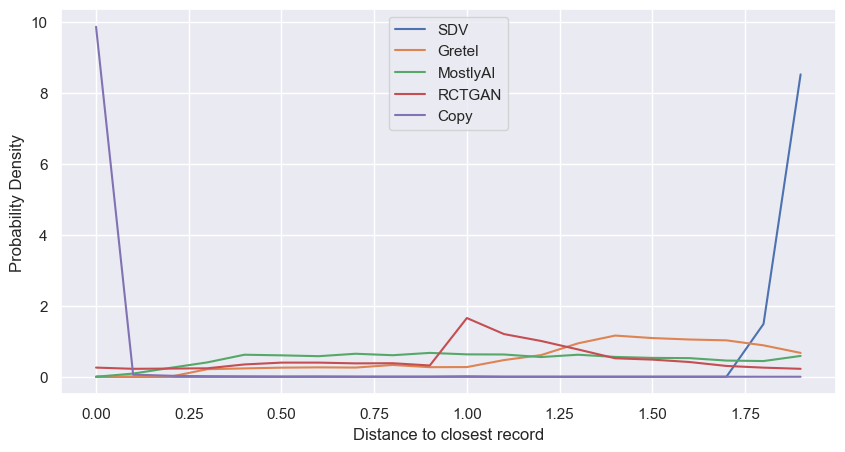

In [32]:
# DCR
nbins = 20
max_dist = 2
freq_sdv, bins = np.histogram(dcr_sdv, bins=nbins, range=(0, max_dist))
freq_gretel, _ = np.histogram(dcr_gretel, bins=nbins, range=(0, max_dist))
freq_mostlyai, _ = np.histogram(dcr_mostlyai, bins=nbins, range=(0, max_dist))
freq_rctgan, _ = np.histogram(dcr_rctgan, bins=nbins, range=(0, max_dist))
freq_cp, _ = np.histogram(dcr_cp, bins=nbins, range=(0, max_dist))

freq_sdv = freq_sdv / freq_sdv.sum()
freq_gretel = freq_gretel / freq_gretel.sum()
freq_mostlyai = freq_mostlyai / freq_mostlyai.sum()
freq_rctgan = freq_rctgan / freq_rctgan.sum()
freq_cp = freq_cp / freq_cp.sum()
w = (bins[1] - bins[0])

# Compute the PDFs
pdf_sdv = freq_sdv / w
pdf_gretel = freq_gretel / w
pdf_mostlyai = freq_mostlyai / w
pdf_rctgan = freq_rctgan / w
pdf_cp = freq_cp / w

# Plot the PDFs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(bins[:-1], pdf_sdv, label='SDV')
ax.plot(bins[:-1], pdf_gretel, label='Gretel')
ax.plot(bins[:-1], pdf_mostlyai, label='MostlyAI')
ax.plot(bins[:-1], pdf_rctgan, label='RCTGAN')
ax.plot(bins[:-1], pdf_cp, label='Copy')
ax.set_xlabel('DCR')
ax.set_ylabel('Probability Density')
ax.set_title('Distance to closest record distributions')
ax.legend()
plt.show()


Distance to closest record distributions look good for all methods, indicating no data copying. Interestingly RCTGAN shows to be copying more than the other methods. This is to be expected, as SDV is unable to fit the data well enough and other methods all postprocess the data with privacy filters during sampling.

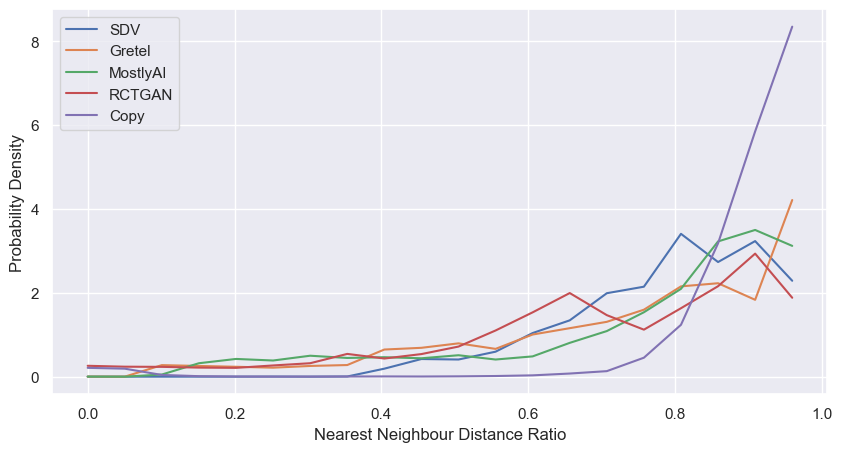

In [19]:
#NNDR
nbins = 20
max_dist = 1.01
freq_sdv, bins = np.histogram(nndr_sdv, bins=nbins, range=(0, max_dist))
freq_gretel, _ = np.histogram(nndr_gretel, bins=nbins, range=(0, max_dist))
freq_mostlyai, _ = np.histogram(nndr_mostlyai, bins=nbins, range=(0, max_dist))
freq_rctgan, _ = np.histogram(nndr_rctgan, bins=nbins, range=(0, max_dist))
freq_cp, _ = np.histogram(nndr_cp, bins=nbins, range=(0, max_dist))

freq_sdv = freq_sdv / freq_sdv.sum()
freq_gretel = freq_gretel / freq_gretel.sum()
freq_mostlyai = freq_mostlyai / freq_mostlyai.sum()
freq_rctgan = freq_rctgan / freq_rctgan.sum()   
freq_cp = freq_cp / freq_cp.sum()
w = (bins[1] - bins[0])

# Compute the PDFs
pdf_sdv = freq_sdv / w
pdf_gretel = freq_gretel / w
pdf_mostlyai = freq_mostlyai / w
pdf_rctgan = freq_rctgan / w
pdf_cp = freq_cp / w

# Plot the PDFs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(bins[:-1], pdf_sdv, label='SDV')
ax.plot(bins[:-1], pdf_gretel, label='Gretel')
ax.plot(bins[:-1], pdf_mostlyai, label='MostlyAI')
ax.plot(bins[:-1], pdf_rctgan, label='RCTGAN')
ax.plot(bins[:-1], pdf_cp, label='Copy')
ax.set_title('Nearest Neighbour Distance Ratio distributions')
ax.set_xlabel('NNDR')
ax.set_ylabel('Probability Density')
ax.legend()
plt.show()


Quialitatively the nearest neighbour distance ratio distributions look good,
indicating no or little data copying.